In [18]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.11.0+cu113]


In [19]:
def torch2np(x_torch):
    if x_torch is None:
        x_np = None
    else:
        x_np = x_torch.detach().cpu().numpy()
    return x_np
def np2torch(x_np,device='cuda:0'):
    if x_np is None:
        x_torch = None
    else:
        x_torch = torch.tensor(x_np,dtype=torch.float32,device=device)
    return x_torch
print ("Done.")

Done.


In [20]:
class VectorQuantizer(nn.Module):
    def __init__(
                self,
                embedding_num   = 10,
                embedding_dim   = 3,
                commitment_beta = 0.25,
                device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
                ):
        super(VectorQuantizer, self).__init__()
        self.embedding_num   = embedding_num
        self.embedding_dim   = embedding_dim
        self.commitment_beta = commitment_beta
        self.device    = device
        self.embedding = nn.Embedding(self.embedding_num, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.embedding_num, 1/self.embedding_num)
        # torch.nn.init.xavier_uniform_(self.embedding.weight)
        # self.embedding.weight.data.fill_(0)
        # self.embedding.weight.data.fill_diagonal_(0.1)

    def compute_loss(
                    self,
                    z_e,
                    z_q
                    ):
        codebook_loss   = F.mse_loss(z_e.detach(), z_q)
        commitment_loss = F.mse_loss(z_e, z_q.detach())
        # return codebook_loss + self.commitment_beta*commitment_loss
        return self.commitment_beta*commitment_loss

    def forward(
                self, 
                z = torch.randn(1, 15)
                ):
        z_dim = z.shape[1]
        z = z.reshape(-1, int(z_dim/self.embedding_dim), self.embedding_dim)
        z_e = z.view(-1, self.embedding_dim)
        distances = torch.sum(z_e**2, dim=1, keepdim=True)\
                    + torch.sum(self.embedding.weight**2, dim=1, keepdim=False)\
                    - 2*torch.matmul(z_e, self.embedding.weight.t())
        q_x = torch.argmin(distances, dim=1).unsqueeze(1)
        q_x_one_hot = torch.zeros(q_x.shape[0], self.embedding_num).to(self.device)
        q_x_one_hot.scatter_(1, q_x, 1)
        z_q  = torch.matmul(q_x_one_hot, self.embedding.weight).view(z.shape)
        loss = self.compute_loss(z, z_q)
        z_q = z + (z_q-z).detach()
        return z_q.reshape(-1, z_dim), loss

In [21]:
class VectorQuantizedVariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        name     = 'VQVAE',              
        x_dim    = 784,              # input dimension
        z_dim    = 15,               # latent dimension
        h_dims   = [64,32],          # hidden dimensions of encoder (and decoder)
        embedding_num   = 10,        # For VQ parameters
        embedding_dim   = 3,         # For VQ parameters
        commitment_beta = 0.25,      # For VQ parameters
        actv_enc = nn.ReLU(),        # encoder activation
        actv_dec = nn.ReLU(),        # decoder activation
        actv_out = None,             # output activation
        var_max  = None,             # maximum variance
        device   = 'cpu'
        ):
        """
            Initialize
        """
        super(VectorQuantizedVariationalAutoEncoder, self).__init__()
        self.name     = name
        self.x_dim    = x_dim
        self.z_dim    = z_dim
        self.h_dims   = h_dims
        self.embedding_num   = embedding_num
        self.embedding_dim   = embedding_dim
        self.commitment_beta = commitment_beta
        self.actv_enc = actv_enc
        self.actv_dec = actv_dec
        self.actv_out = actv_out
        self.var_max  = var_max
        self.device   = device
        # Initialize VQ class
        self.VQ = VectorQuantizer(self.embedding_num, self.embedding_dim, self.commitment_beta).to(self.device)
        # Initialize layers
        self.init_layers()
        self.init_params()
                
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        
        # Encoder part
        h_dim_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = \
                self.actv_enc
            h_dim_prev = h_dim
        self.layers['z_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        
        # Decoder part
        h_dim_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = \
                self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.cvae_parameters = nn.ParameterDict(self.param_dict)
        
    def x_to_z(
        self,
        x = torch.randn(2,784)
        ):
        """
            x to z
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z = self.layers['z_lin'](net)
        return z
    
    def z_to_x_recon(
        self,
        z
        ):
        """
            z and c to x_recon
        """
        net, _ = self.VQ(z)
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def z_q_to_x_recon(
        self,
        z_q
        ):
        """
            z and c to x_recon
        """
        net = z_q
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon

    def x_to_x_recon(
        self,
        x = torch.randn(2,784),
        ):
        """
            x to x_recon
        """
        z = self.x_to_z(x=x)
        x_recon = self.z_to_x_recon(z=z)
        return x_recon
    
    def init_params(self,seed=0):
        """
            Initialize parameters
        """
        # Fix random seed
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        # Init
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.01)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def loss_recon(
        self,
        x               = torch.randn(2,784),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Recon loss
        """
        x_recon = self.x_to_x_recon(x=x)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        return recon_loss_gain*torch.mean(errs)
        
    def loss_total(
        self,
        x               = torch.randn(2,784),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0
        ):
        """
            Total loss
        """
        loss_recon_out = self.loss_recon(
            x               = x,
            LOSS_TYPE       = LOSS_TYPE,
            recon_loss_gain = recon_loss_gain
        )
        z = self.x_to_z(x)
        _, loss_vq = self.VQ(z)
        loss_total_out = loss_recon_out + loss_vq
        info           = {'loss_total_out' : loss_total_out,
                          'loss_recon_out' : loss_recon_out,
                          'loss_vq'        : loss_vq}
        return loss_total_out,info

    def debug_plot_img(
        self,
        x_train_np     = np.zeros((60000,784)),  # to plot encoded latent space 
        y_train_np     = np.zeros((60000)),      # to plot encoded latent space 
        c_train_np     = np.zeros((60000,10)),   # to plot encoded latent space
        x_test_np      = np.zeros((10000,784)),
        c_test_np      = np.zeros((10000,10)),
        c_vecs         = np.eye(10,10),
        n_sample       = 10,
        img_shape      = (28,28),
        img_cmap       = 'gray',
        figsize_image  = (10,3.25),
        figsize_latent = (10,3.25),
        DPP_GEN        = False,
        dpp_hyp        = {'g':1.0,'l':0.1}
        ):
        """
            Debug plot
        """
        n_train       = x_train_np.shape[0]
        x_train_torch = np2torch(x_train_np, device=self.device)
        # Reconstruct
        x_test_torch  = np2torch(x_test_np, device=self.device)
        n_test        = x_test_np.shape[0]
        rand_idxs     = np.random.permutation(n_test)[:n_sample]
        x_recon = self.x_to_x_recon(x=x_test_torch[rand_idxs,:]).detach().cpu().numpy()
        # Generation
        random_integers  = np.random.permutation(self.embedding_num)[:n_sample]
        random_embedding = self.VQ.embedding.weight.data[random_integers, :]
        x_sample = self.z_q_to_x_recon(z_q=random_embedding).detach().cpu().numpy()
        # Plot images to reconstruct
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_test_np[rand_idxs[s_idx],:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Images to Reconstruct",fontsize=15);plt.show()
        
        # Plot reconstructed images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_recon[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Reconstructed Images",fontsize=15);plt.show()

        # Plot generated images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_sample[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Generated Images",fontsize=15);plt.show()

In [22]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch               = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch               = mnist_train.targets
x_test_torch                = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch                = mnist_test.targets
x_train_np,x_test_np        = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np        = torch2np(y_train_torch),torch2np(y_test_torch)
c_train_np,c_test_np        = np.eye(10,10)[y_train_np],np.eye(10,10)[y_test_np]
n_train,n_test              = x_train_np.shape[0],x_test_np.shape[0]
c_train_torch,c_test_torch  = np2torch(c_train_np),np2torch(c_test_np)
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("c_train_np:%s c_test_np:%s"%(c_train_np.shape,c_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
c_train_np:(60000, 10) c_test_np:(10000, 10)
n_train:[60000] n_test:[10000]


tensor([[ 0.0222,  0.0166,  0.0115,  ...,  0.0056,  0.0093, -0.0144],
        [ 0.0020,  0.0272, -0.0219,  ...,  0.0126,  0.0259, -0.0111],
        [-0.0018,  0.0137,  0.0156,  ..., -0.0046,  0.0268,  0.0236],
        ...,
        [-0.0215, -0.0017,  0.0221,  ...,  0.0303,  0.0032, -0.0129],
        [ 0.0268, -0.0286, -0.0083,  ...,  0.0108,  0.0294,  0.0073],
        [ 0.0023,  0.0125,  0.0301,  ...,  0.0125,  0.0058, -0.0044]],
       device='cuda:0')
[VQVAE] instantiated with device:[cuda:0]
Start training.
[0/100] total:[0.217] recon:[0.097] vq:[1191.997]


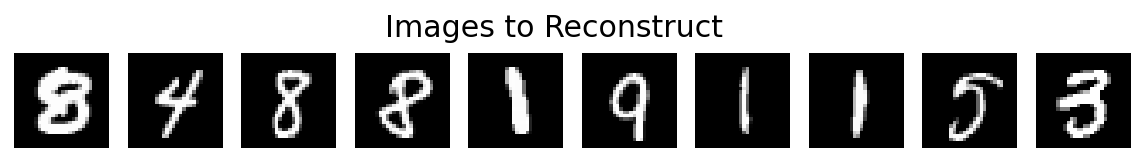

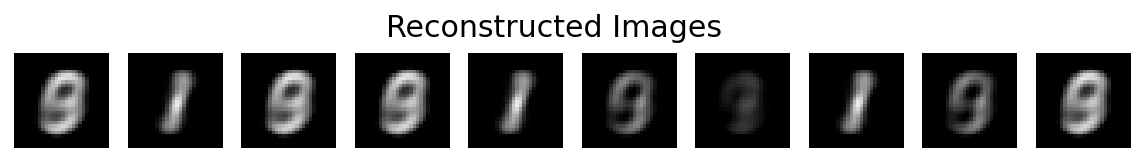

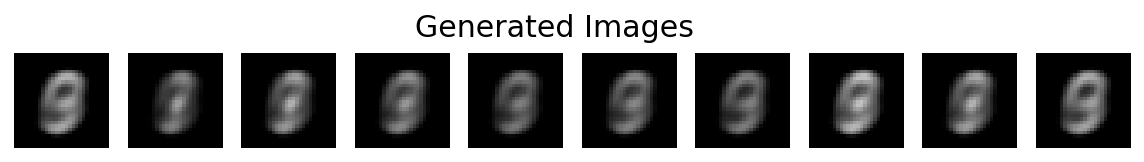

[1/100] total:[0.629] recon:[0.091] vq:[5375.169]
[2/100] total:[0.515] recon:[0.091] vq:[4240.955]
[3/100] total:[0.396] recon:[0.090] vq:[3053.158]
[4/100] total:[0.398] recon:[0.089] vq:[3080.615]
[5/100] total:[0.520] recon:[0.088] vq:[4322.145]


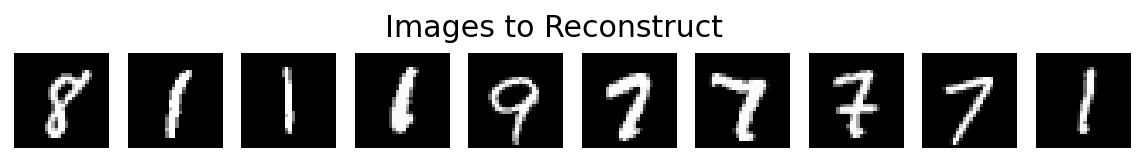

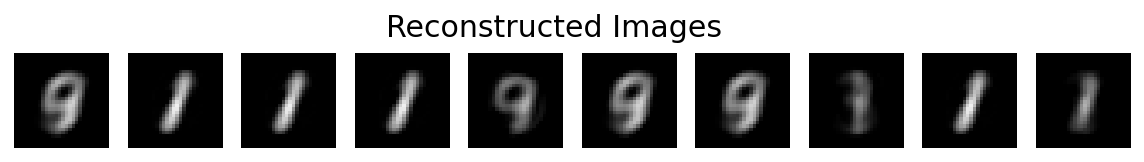

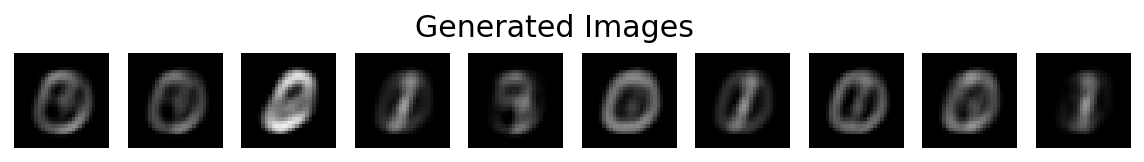

[6/100] total:[0.689] recon:[0.087] vq:[6025.539]
[7/100] total:[0.984] recon:[0.086] vq:[8985.122]
[8/100] total:[0.922] recon:[0.086] vq:[8356.642]
[9/100] total:[1.075] recon:[0.086] vq:[9894.463]
[10/100] total:[1.442] recon:[0.084] vq:[13582.145]


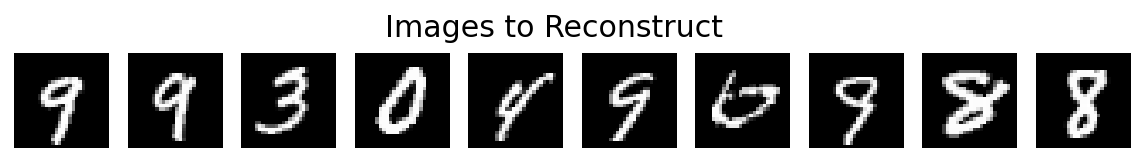

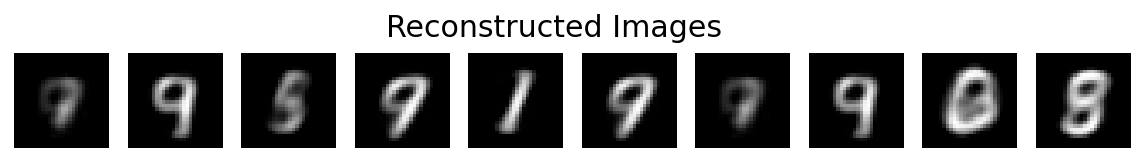

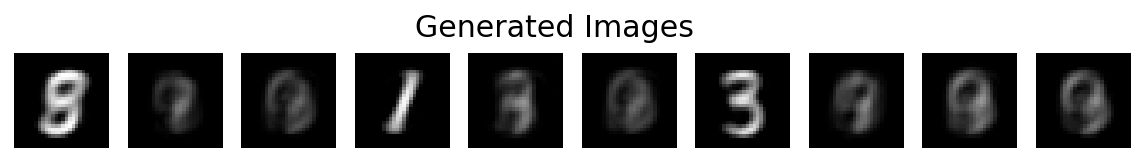

[11/100] total:[1.413] recon:[0.083] vq:[13301.381]
[12/100] total:[1.479] recon:[0.082] vq:[13972.666]
[13/100] total:[1.590] recon:[0.081] vq:[15091.543]
[14/100] total:[1.757] recon:[0.081] vq:[16759.629]
[15/100] total:[1.945] recon:[0.080] vq:[18642.645]


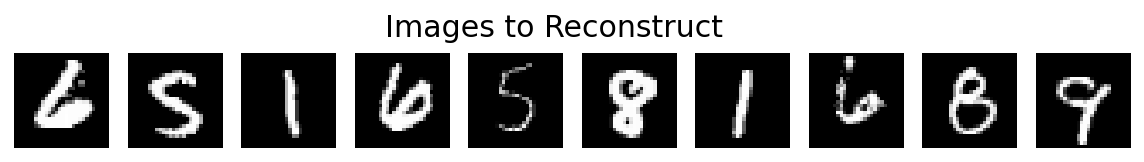

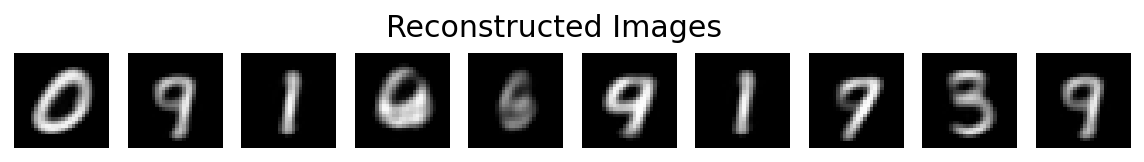

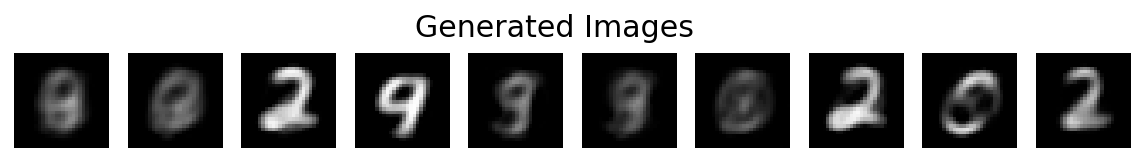

[16/100] total:[2.013] recon:[0.080] vq:[19326.590]
[17/100] total:[2.019] recon:[0.080] vq:[19386.010]
[18/100] total:[2.097] recon:[0.080] vq:[20170.594]
[19/100] total:[2.218] recon:[0.080] vq:[21386.318]
[20/100] total:[2.209] recon:[0.080] vq:[21289.391]


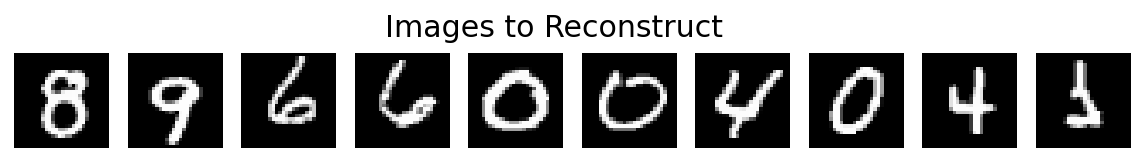

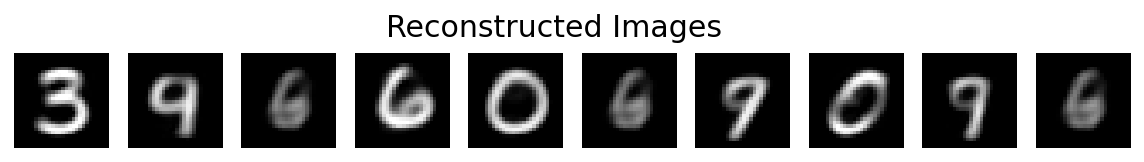

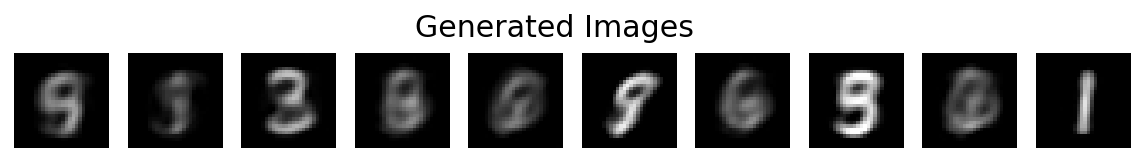

[21/100] total:[2.217] recon:[0.080] vq:[21374.793]
[22/100] total:[2.276] recon:[0.079] vq:[21963.678]
[23/100] total:[2.156] recon:[0.079] vq:[20770.430]
[24/100] total:[2.094] recon:[0.079] vq:[20148.844]
[25/100] total:[2.147] recon:[0.079] vq:[20670.666]


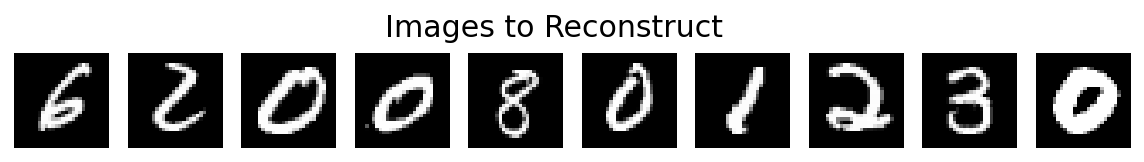

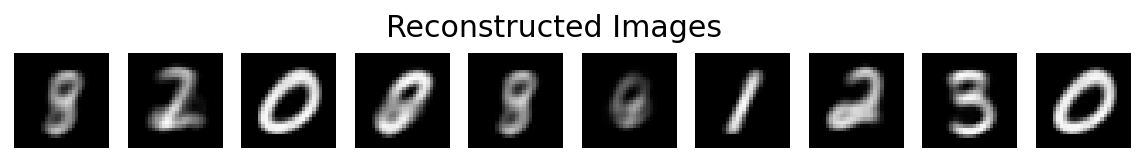

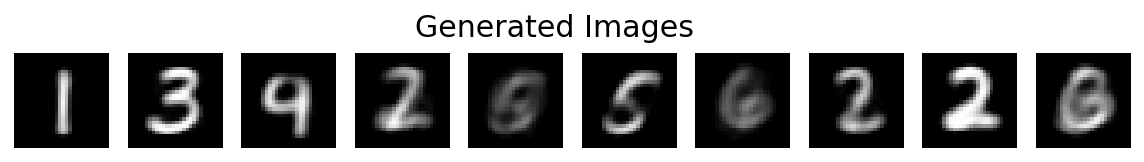

[26/100] total:[2.146] recon:[0.080] vq:[20666.795]
[27/100] total:[2.093] recon:[0.080] vq:[20127.094]
[28/100] total:[2.084] recon:[0.080] vq:[20035.387]
[29/100] total:[1.986] recon:[0.080] vq:[19059.916]
[30/100] total:[1.946] recon:[0.080] vq:[18654.512]


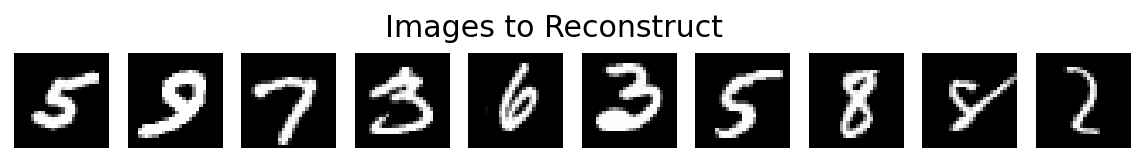

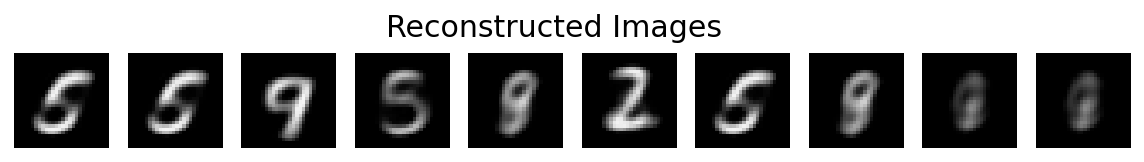

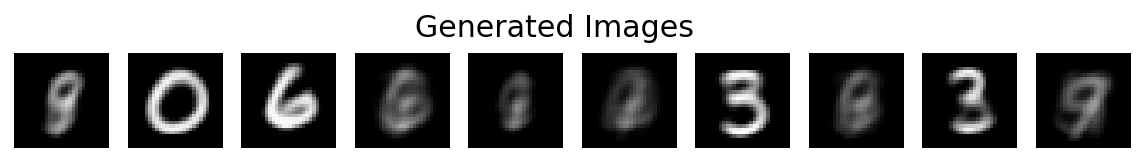

[31/100] total:[1.959] recon:[0.080] vq:[18791.582]
[32/100] total:[2.021] recon:[0.080] vq:[19408.326]
[33/100] total:[2.119] recon:[0.080] vq:[20395.920]
[34/100] total:[2.167] recon:[0.080] vq:[20867.650]
[35/100] total:[2.113] recon:[0.080] vq:[20329.918]


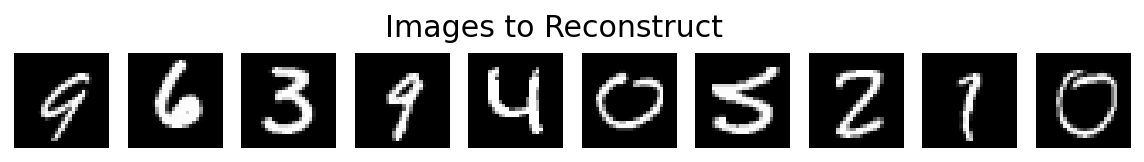

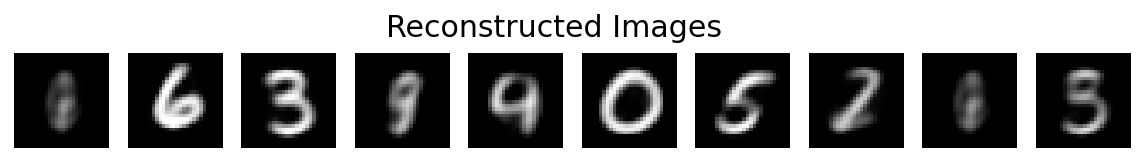

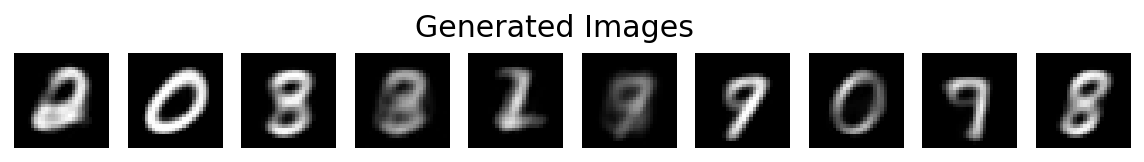

[36/100] total:[2.110] recon:[0.080] vq:[20308.064]
[37/100] total:[2.109] recon:[0.079] vq:[20299.469]
[38/100] total:[2.056] recon:[0.079] vq:[19771.537]
[39/100] total:[2.090] recon:[0.079] vq:[20103.027]
[40/100] total:[2.164] recon:[0.080] vq:[20842.541]


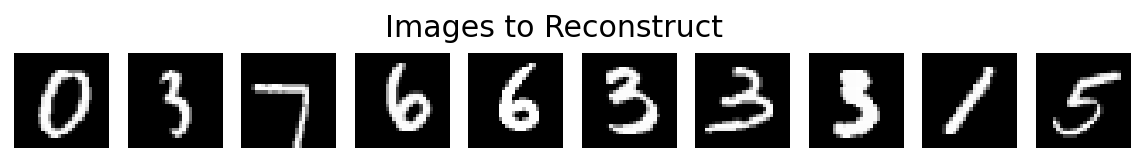

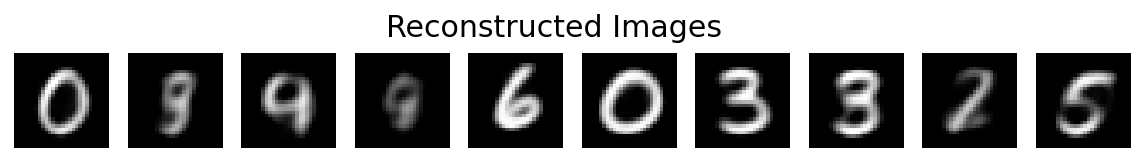

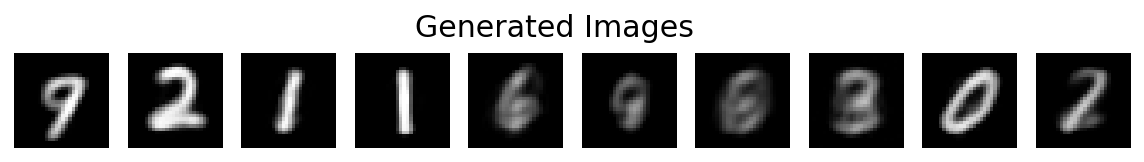

[41/100] total:[2.139] recon:[0.080] vq:[20591.379]
[42/100] total:[2.110] recon:[0.080] vq:[20295.920]
[43/100] total:[2.076] recon:[0.080] vq:[19960.682]
[44/100] total:[2.034] recon:[0.080] vq:[19540.850]
[45/100] total:[2.022] recon:[0.080] vq:[19413.691]


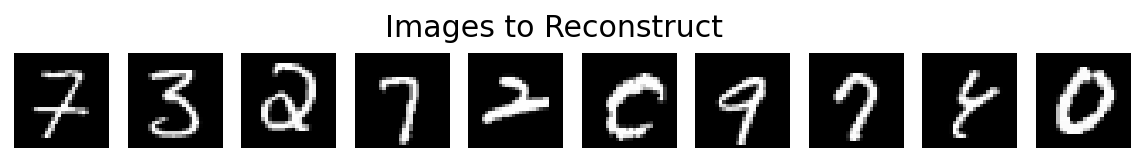

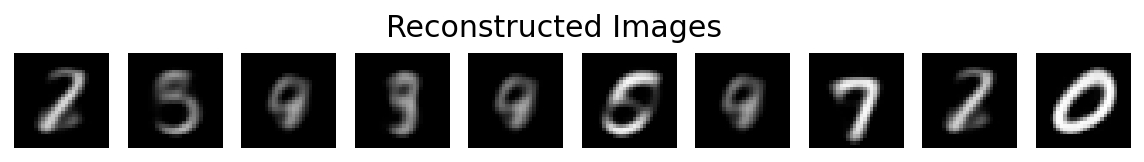

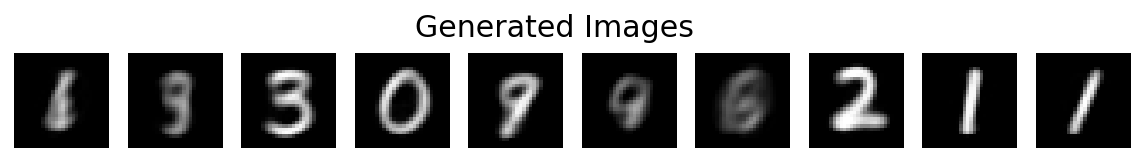

[46/100] total:[1.973] recon:[0.080] vq:[18924.785]
[47/100] total:[2.124] recon:[0.080] vq:[20440.756]
[48/100] total:[2.168] recon:[0.079] vq:[20891.848]
[49/100] total:[2.268] recon:[0.079] vq:[21884.752]
[50/100] total:[2.183] recon:[0.079] vq:[21034.324]


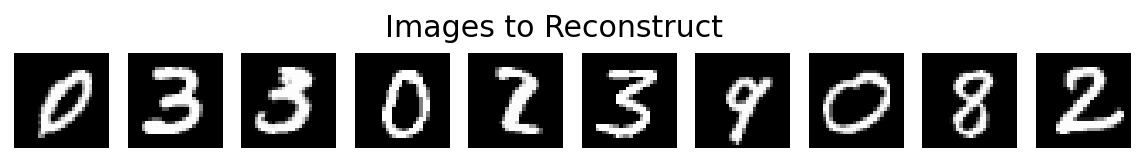

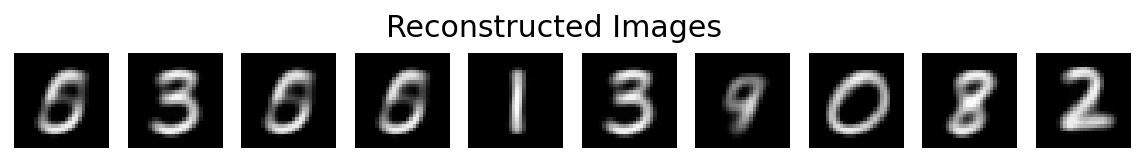

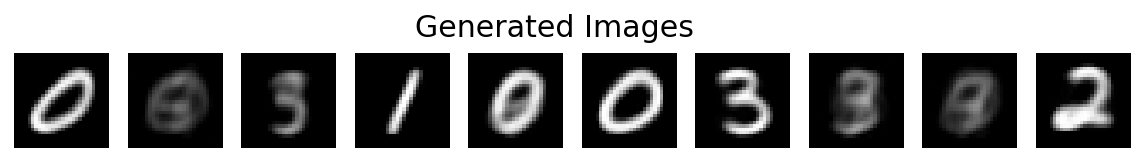

[51/100] total:[2.241] recon:[0.079] vq:[21620.545]
[52/100] total:[2.233] recon:[0.079] vq:[21540.320]
[53/100] total:[2.086] recon:[0.079] vq:[20062.268]
[54/100] total:[1.995] recon:[0.080] vq:[19155.482]
[55/100] total:[1.821] recon:[0.081] vq:[17401.984]


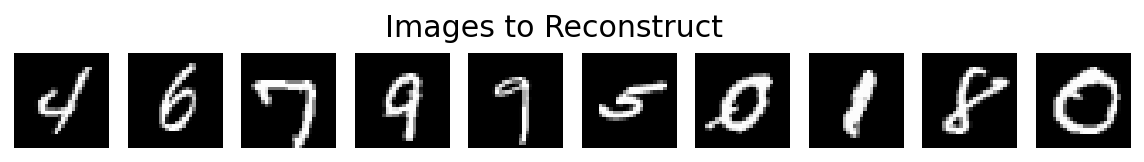

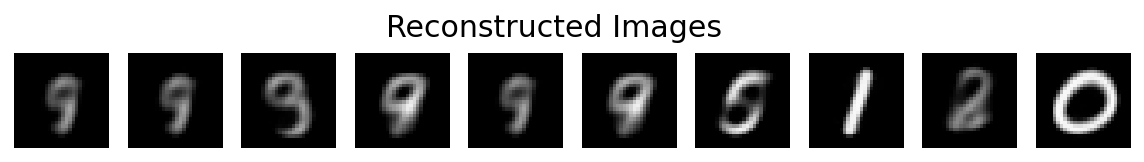

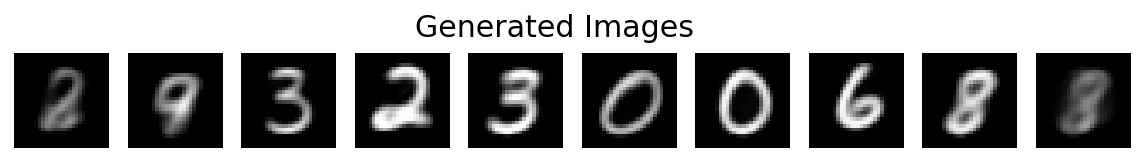

[56/100] total:[1.882] recon:[0.081] vq:[18007.795]
[57/100] total:[1.800] recon:[0.081] vq:[17193.246]
[58/100] total:[1.749] recon:[0.081] vq:[16683.865]
[59/100] total:[1.716] recon:[0.081] vq:[16351.633]
[60/100] total:[1.812] recon:[0.081] vq:[17306.807]


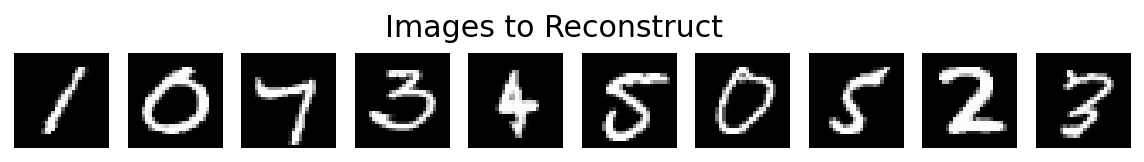

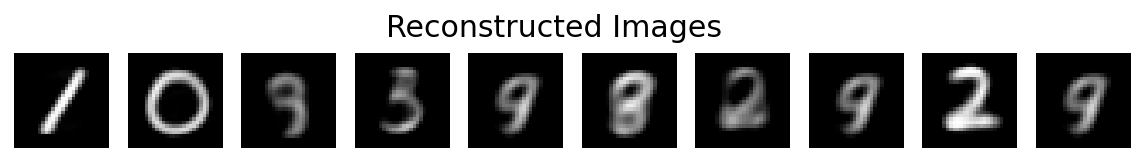

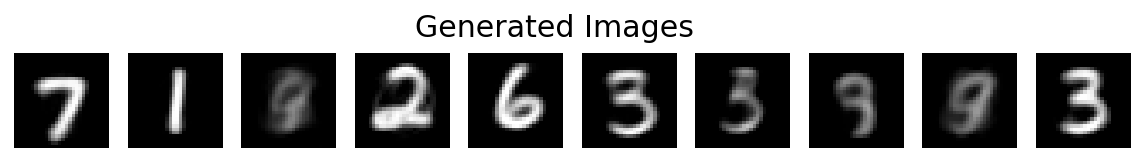

[61/100] total:[1.685] recon:[0.082] vq:[16025.375]
[62/100] total:[1.796] recon:[0.082] vq:[17146.145]
[63/100] total:[1.898] recon:[0.082] vq:[18161.898]
[64/100] total:[2.014] recon:[0.083] vq:[19311.395]
[65/100] total:[2.008] recon:[0.082] vq:[19255.488]


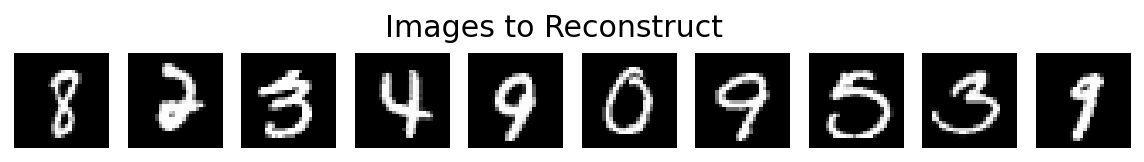

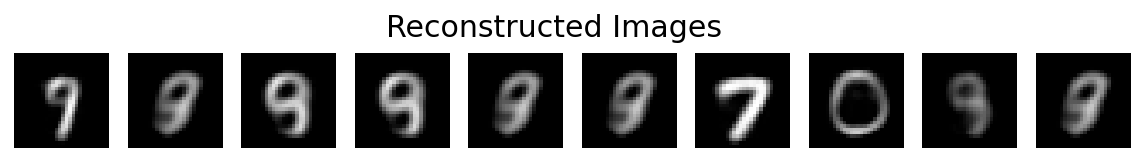

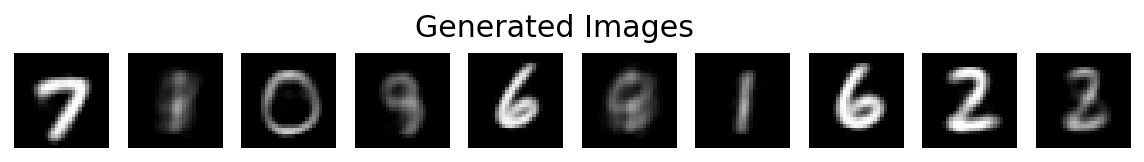

[66/100] total:[2.012] recon:[0.083] vq:[19296.662]
[67/100] total:[1.940] recon:[0.082] vq:[18573.188]
[68/100] total:[1.935] recon:[0.083] vq:[18525.107]
[69/100] total:[1.882] recon:[0.083] vq:[17990.564]
[70/100] total:[1.926] recon:[0.082] vq:[18441.143]


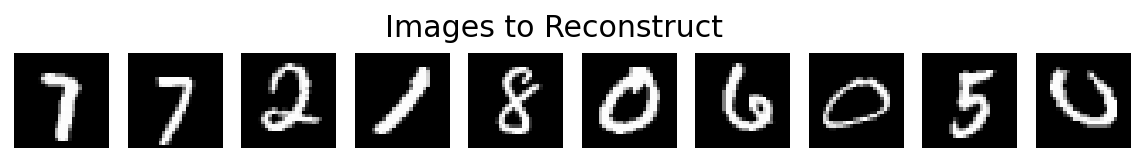

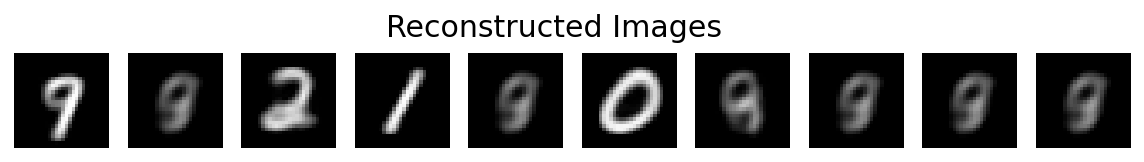

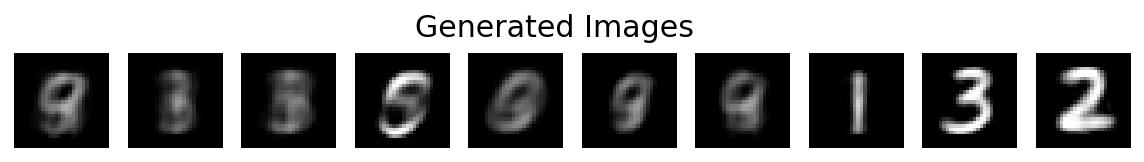

[71/100] total:[2.008] recon:[0.081] vq:[19268.949]
[72/100] total:[1.910] recon:[0.081] vq:[18283.326]
[73/100] total:[2.013] recon:[0.081] vq:[19313.314]
[74/100] total:[2.122] recon:[0.080] vq:[20417.469]
[75/100] total:[2.109] recon:[0.080] vq:[20283.465]


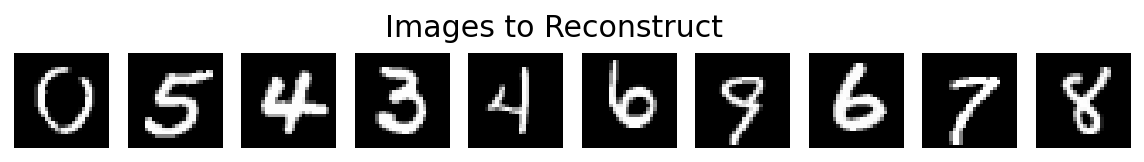

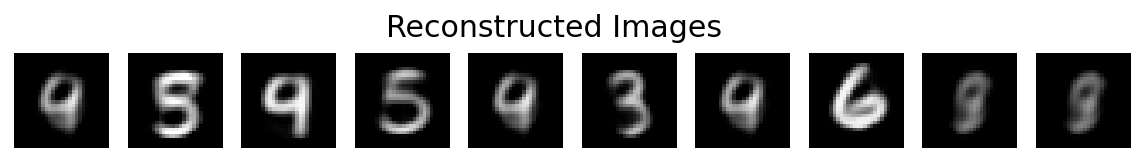

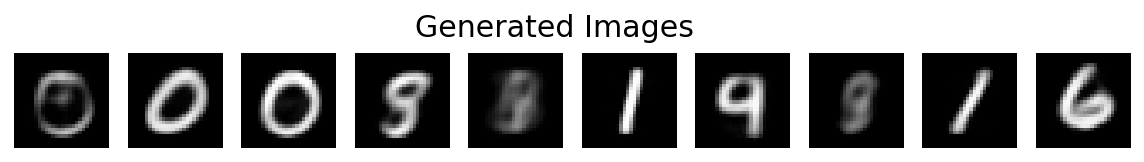

[76/100] total:[2.083] recon:[0.080] vq:[20024.006]
[77/100] total:[2.135] recon:[0.080] vq:[20548.811]
[78/100] total:[2.154] recon:[0.080] vq:[20744.463]
[79/100] total:[2.160] recon:[0.080] vq:[20803.967]
[80/100] total:[2.182] recon:[0.080] vq:[21024.730]


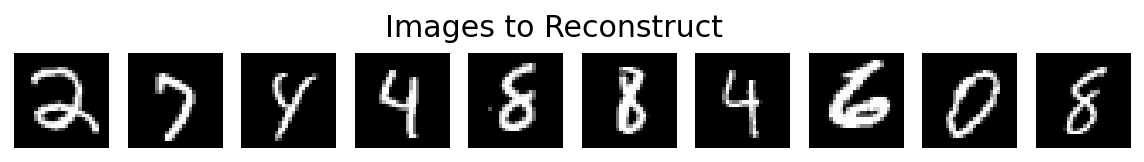

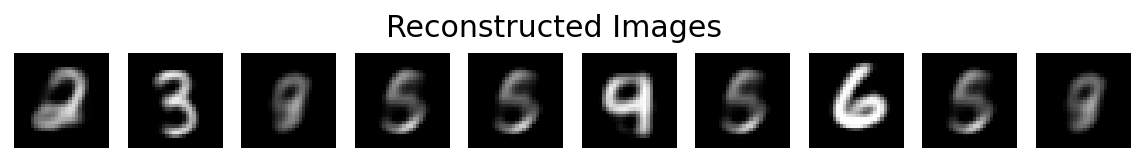

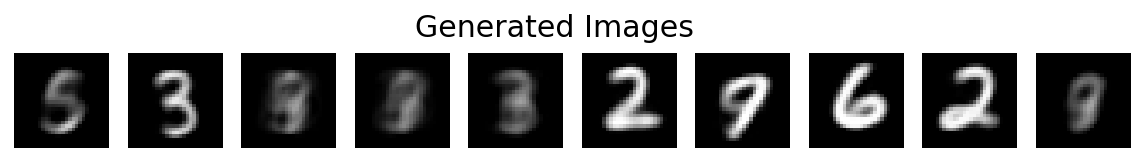

[81/100] total:[2.140] recon:[0.080] vq:[20603.375]
[82/100] total:[2.121] recon:[0.080] vq:[20410.088]
[83/100] total:[2.126] recon:[0.080] vq:[20458.674]
[84/100] total:[2.064] recon:[0.080] vq:[19836.797]
[85/100] total:[2.224] recon:[0.080] vq:[21434.918]


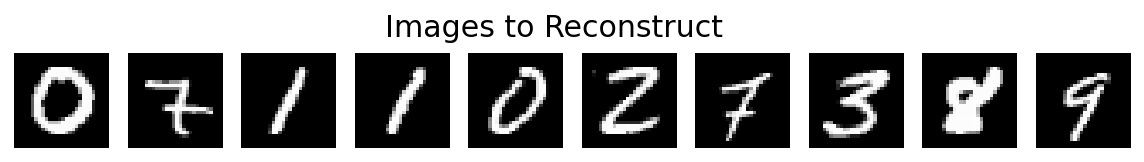

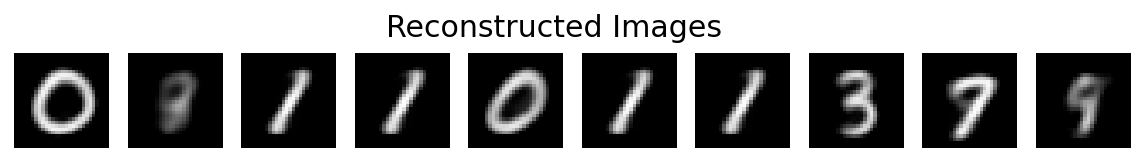

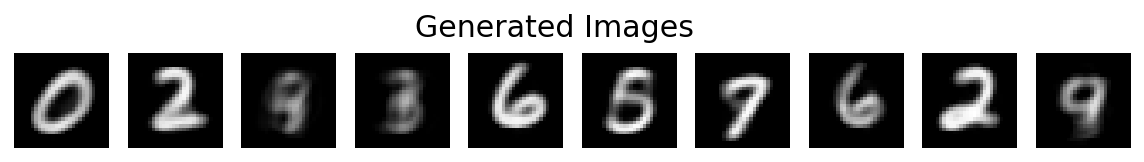

[86/100] total:[2.109] recon:[0.080] vq:[20282.068]
[87/100] total:[2.047] recon:[0.080] vq:[19667.459]
[88/100] total:[2.068] recon:[0.079] vq:[19887.725]
[89/100] total:[2.014] recon:[0.079] vq:[19346.984]
[90/100] total:[2.048] recon:[0.079] vq:[19681.410]


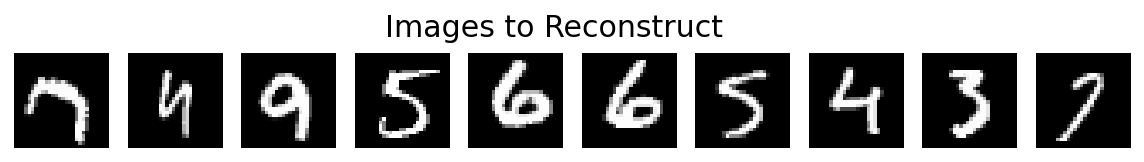

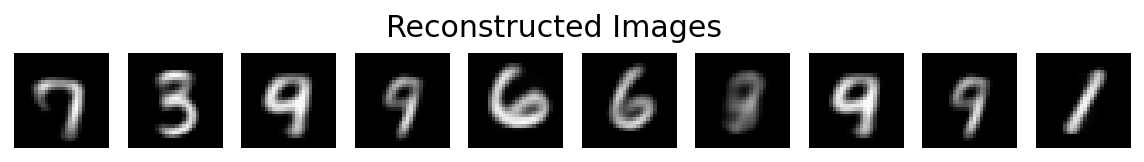

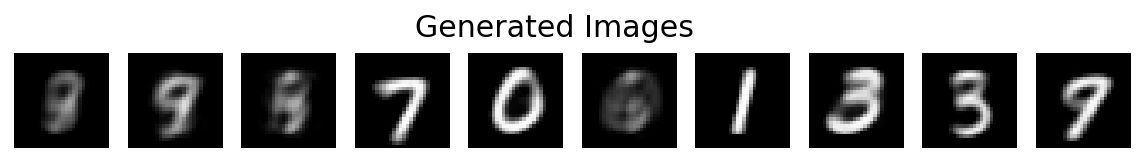

[91/100] total:[2.051] recon:[0.080] vq:[19717.074]
[92/100] total:[2.024] recon:[0.080] vq:[19436.670]
[93/100] total:[2.040] recon:[0.080] vq:[19598.160]
[94/100] total:[2.075] recon:[0.080] vq:[19943.592]
[95/100] total:[2.116] recon:[0.080] vq:[20360.008]


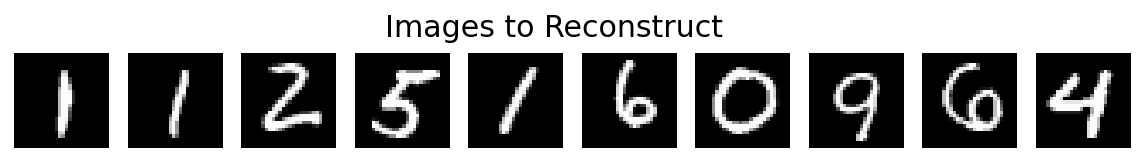

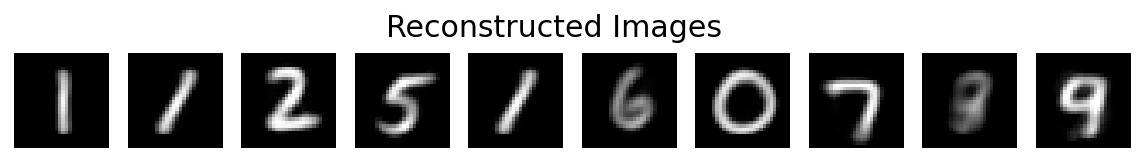

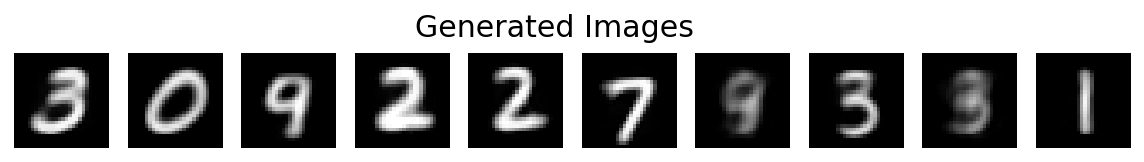

[96/100] total:[2.123] recon:[0.080] vq:[20423.717]
[97/100] total:[2.116] recon:[0.080] vq:[20359.145]
[98/100] total:[2.191] recon:[0.080] vq:[21108.920]
[99/100] total:[2.143] recon:[0.080] vq:[20629.490]


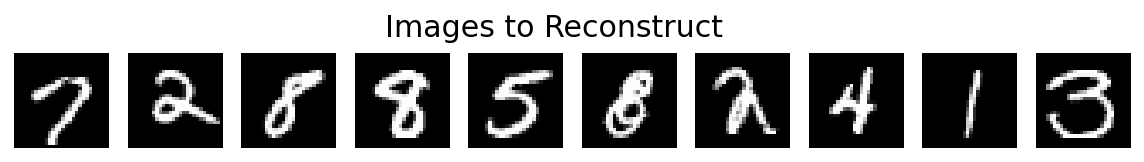

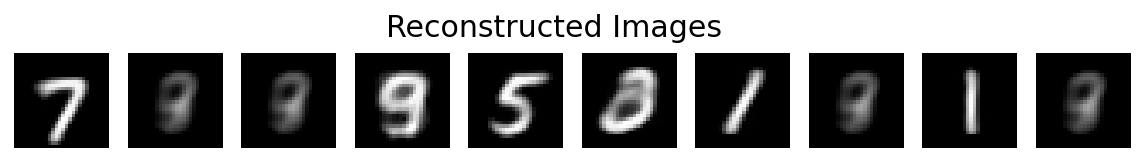

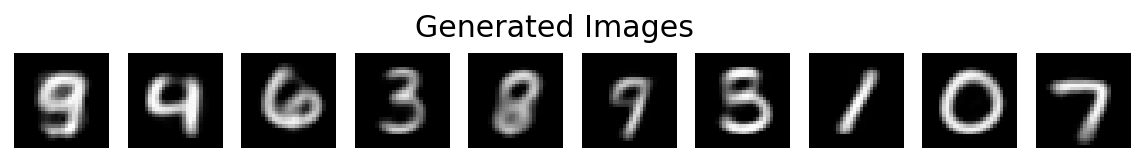

Done.


In [23]:
VQVAE = VectorQuantizedVariationalAutoEncoder(
                                            name     = 'VQVAE',
                                            x_dim    = 784,
                                            z_dim    = 32,
                                            h_dims   = [256,256],
                                            embedding_num   = 32,
                                            embedding_dim   = 32,
                                            commitment_beta = 0.25,
                                            actv_enc = nn.ReLU(),
                                            actv_dec = nn.ReLU(),
                                            actv_out = None,
                                            var_max  = None,
                                            device   ='cuda:0'
                                            )
print(VQVAE.VQ.embedding.weight.data)
VQVAE = VQVAE.to(VQVAE.device)
print ("[{}] instantiated with device:[{}]".format(VQVAE.name, VQVAE.device))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,5
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = VQVAE.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-8        # 1e-8
) 
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':c_train_np,
       'x_test_np':x_test_np,'c_test_np':c_test_np,'c_vecs':np.eye(10,10),
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# C.debug_plot_img(**dpi)
print ("Start training.")
x_train_torch = x_train_torch.to(VQVAE.device)
c_train_torch = c_train_torch.to(VQVAE.device)
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    loss_recon_sum,loss_vq_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = c_train_torch[batch_idx,:]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = VQVAE.loss_total(
            x               = x_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 1.0)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_vq_sum    = loss_vq_sum + n_batch*loss_info['loss_vq']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_vq_avg    = loss_vq_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] vq:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg, 10000*loss_vq_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        VQVAE.debug_plot_img(**dpi)
print ("Done.")

In [24]:
print(VQVAE.VQ.embedding.weight.data.shape)

torch.Size([32, 32])


In [25]:
torch.cov(VQVAE.VQ.embedding.weight.data)

tensor([[ 2.0756e-04,  4.3468e-05,  6.1442e-05,  ...,  7.7679e-05,
          6.8192e-05,  2.6097e-05],
        [ 4.3468e-05,  3.2586e-04, -2.2420e-05,  ...,  5.2958e-05,
          1.8439e-05,  4.6114e-07],
        [ 6.1442e-05, -2.2420e-05,  2.9892e-04,  ..., -3.2992e-06,
          7.4306e-05, -3.9563e-05],
        ...,
        [ 7.7679e-05,  5.2958e-05, -3.2992e-06,  ...,  2.6428e-04,
          5.6824e-05, -1.1795e-05],
        [ 6.8192e-05,  1.8439e-05,  7.4306e-05,  ...,  5.6824e-05,
          4.4459e-04, -3.5356e-05],
        [ 2.6097e-05,  4.6114e-07, -3.9563e-05,  ..., -1.1795e-05,
         -3.5356e-05,  2.4240e-04]], device='cuda:0')